## XGBoost Regression analysis of atmospheric emissions

In [3]:
# import libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

,co2,nox,pm10,pm2.5
0,31.262027,0.135768,0.014352,0.008164
1,4190.712040,16.716902,0.888255,0.536764
2,1849.507166,7.173389,0.400552,0.238611
3,31.158879,0.156213,0.016544,0.010265
4,28.133333,0.158901,0.016852,0.011086
...,...,...,...,...
40675,268.764076,0.225646,0.050658,0.022702
40676,1307.588067,0.933334,0.309936,0.137778
40677,1654.324756,1.342779,0.398525,0.177336
40678,96.064233,0.146172,0.030548,0.013716


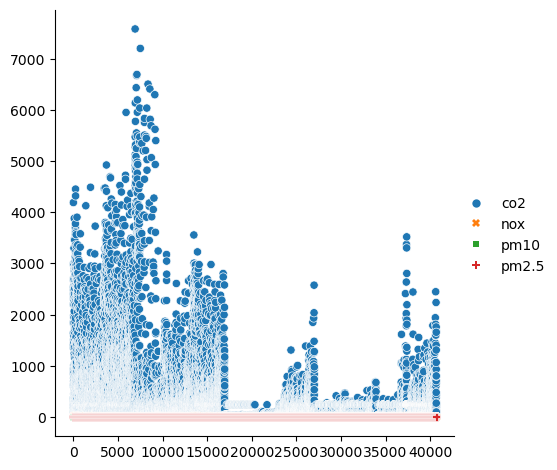

In [4]:
# Read cleaned dataset
emissions_df = pd.read_csv('dataset_cleaned-v1.csv')
sns.relplot(emissions_df)
emissions_df

In [3]:
emissions_df.describe()

,co2,nox,pm10,pm2.5
count,4.068000e+04,4.068000e+04,4.068000e+04,4.068000e+04
mean,2.514171e+02,5.631462e-01,6.690753e-02,3.502392e-02
std,5.366679e+02,1.363688e+00,1.295888e-01,6.824931e-02
min,1.593777e-07,1.012640e-10,5.126055e-11,2.342577e-11
25%,7.454598e+00,8.091197e-03,1.980033e-03,1.028232e-03
50%,4.615726e+01,8.137263e-02,1.216882e-02,6.258806e-03
75%,2.376975e+02,5.331209e-01,6.429495e-02,3.365632e-02
max,7.585041e+03,1.703945e+01,1.400565e+00,7.571128e-01


<font color=blue>We will consider:
- Features: [nox, pm10, pm2.5]
- Target: [co2] </font>

In [4]:
# Splitting columns into features and target
X = emissions_df.filter(items=['nox', 'pm2.5', 'pm10'])
y = emissions_df.filter(items=['co2'])


In [5]:
emissions_df['co2'].sort_values()

38191    1.593777e-07
18937    5.105906e-07
38757    1.144312e-06
22294    3.044698e-06
35901    3.102503e-06
             ...     
8366     6.506760e+03
7096     6.675206e+03
7124     6.695530e+03
7504     7.204749e+03
6921     7.585041e+03
Name: co2, Length: 40680, dtype: float64

## Model training with standard split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
model = XGBRegressor(booster='gbtree', 
                        random_state=42, 
                        objective='reg:squarederror')
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


print('R-squared model score: %.4f' % model.score(X_test,y_test))
print('Mean squared error: %.4f' % mse)
print('Root mean squared error: %.4f' % np.sqrt(mse))

R-squared model score: 0.9496
Mean squared error: 14679.8535
Root mean squared error: 121.1604


<Axes: title={'center': 'XGBRegressor Feature importances'}, xlabel='Importance score', ylabel='Features'>

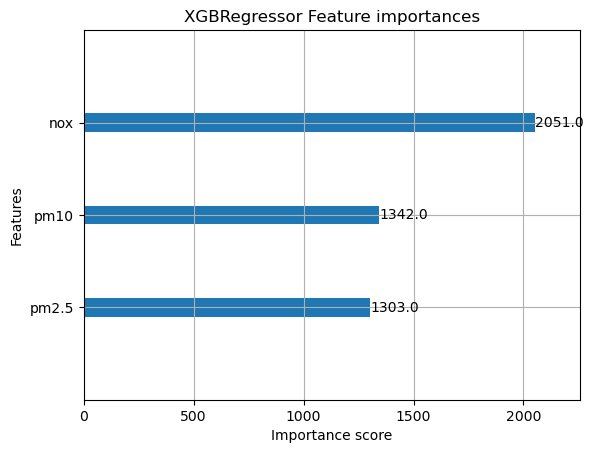

In [8]:
xgb.plot_importance(model,title='XGBRegressor Feature importances')

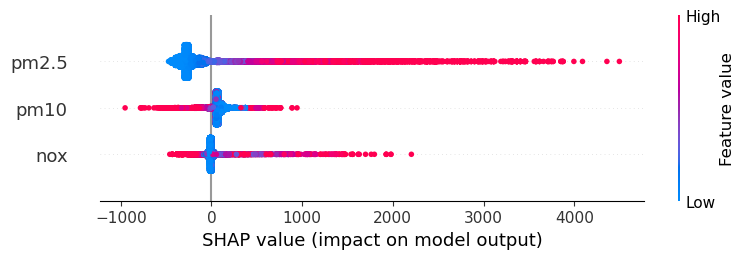

In [9]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

## Finding best parameters using KFold and GridSerarch for cross-validation

In [10]:
%%time 

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

model = XGBRegressor(booster='gbtree', 
                        random_state=42, 
                        objective='reg:squarederror')

params = {
            'eta':[0.05, 0.1, 0.2],
            'n_estimators':[50, 100, 150],
            'max_depth':[4, 5, 6],
            'subsample': [0.6],
            'min_child_weight':[5, 6, 7],
            'reg_lambda':[0.05, 0.1, 0.5]
          }
grid_search = GridSearchCV(model, params, cv=kfold)

grid_search.fit(X_train,y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best params: ', best_params)
print('Best score: %.4f' % best_score)

Best params:  {'eta': 0.2, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 150, 'reg_lambda': 0.1, 'subsample': 0.6}
Best score: 0.9589
CPU times: user 5min 52s, sys: 1min 25s, total: 7min 18s
Wall time: 46.2 s


## XGBoost Regression model using best parameters

In [11]:
%%time 
model = XGBRegressor(booster='gbtree', 
                        random_state=42, 
                        objective='reg:squarederror',
                        n_estimators=150,
                        eta=0.2, 
                        # below hyperparameters to reduce overfitting
                        max_depth=6,
                        subsample=0.6,
                        min_child_weight=6,
                        # L2 (reg_lambda) regularization
                        reg_lambda=0.1
                        )   
                        
model.fit(X_train,y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred = model.predict(X_test)


print('R-squared model score: %.4f' % model.score(X_test,y_test))

mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: %.4f' % mse)
print('Root mean squared error: %.4f' % np.sqrt(mse))


R-squared model score: 0.9551
Mean squared error: 13072.8154
Root mean squared error: 114.3364
CPU times: user 766 ms, sys: 222 ms, total: 989 ms
Wall time: 110 ms


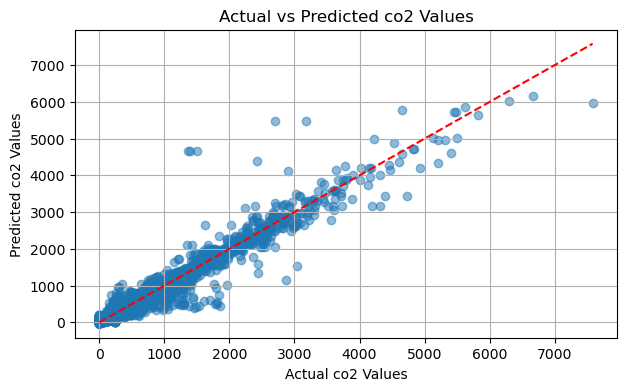

In [12]:

plt.figure(figsize=(7, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.xlabel('Actual co2 Values')
plt.ylabel('Predicted co2 Values')
plt.title('Actual vs Predicted co2 Values')
plt.grid()
plt.show()



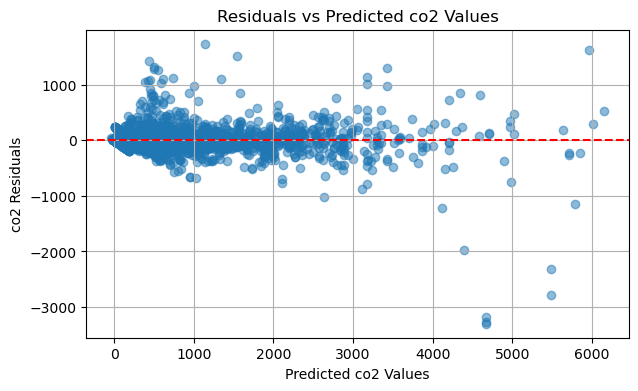

In [13]:

residuals = y_test.values - pd.DataFrame(y_pred).values
plt.figure(figsize=(7, 4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel('Predicted co2 Values')
plt.ylabel('co2 Residuals')
plt.title('Residuals vs Predicted co2 Values')
plt.grid()
plt.show()